Uvozimo pakete in pomožne datoteke. Nastavimo koliko je največje število celic v razpredelnici, ki jih program prikaže ter z vrstico `%matplotlib inline` poskrbimo, da program lahko izriše grafe direktno pod celico s kodo.

In [1]:
import main
import pandas as pd
import os
from spremenljivke import *

# %matplotlib inline
pd.set_option("display.max_rows", 50)

V tej celici lahko (in vas spodbujam, da to tudi naredite) zamenjate podatke. 
v prvi vrstici lahko spremenite dva parametra `od` in `do`. Ta dva parametra povesta od katere do vključno katere strani želite analizirati slovar. Strani je 4884, in za pridobitev vseh teh podatkov računalnik potrebuje približno 5 ur (vsaj moj računalnik je porabil toliko, ampak priznam, da nima veliko RAMa). Program potrebuje približno 2,5 sekunde na stran, zato priporočam da se omejite na 10 strani.

Če ste enkrat to funkcijo že pognali in si želite zajeti druge podatke lahko spremenite vresdnosti `downlovdaj` in `pocsvjaj` na `True`. Tako se bo program izvedel še enkrat, kljub temu, da že imate te podatke.

In [2]:
main.main(downlovdaj=True, pocsvjaj=True, od=1, do=2)

v procesu pridobivanja html-ja...
stran 1
stran 2
v procesu pridobivanja posatkov iz htmlja v csv...
regexanje...
html0.html
Končano


In [3]:
mapa = mapa_slovar

Pridobimo željene podatke. Najprej funkcija `main.main()` pridobi podatke iz interneta in jih pospravi v datoteko, shranjeni v mapi `slovar` v csv datoteki `besede.csv`. Pot do te datoteke je shranjena v spremenljivki `pot_slovar_csv` iz datoteke `spremenljivke.py`. 
Pod spremenljivko `raz` shranimo razpredelnico pridobljenih podatkov slovarja.

In [4]:
pot_slovar_csv = os.path.join(mapa, csv)
razpredelnica = pd.read_csv(pot_slovar_csv)
razpredelnica.count()

ime      40
vrsta    34
dtype: int64

Poglejmo si koliko je posamezne besedne vrste.

Funkcija `štetje_stolpca` prešteje kolikokrat se vsaka različna vrednost v stolpcu ponovi ter jih uredi po padajočih vrednostih. 
To uporabimo na stolpcu `vrsta`. 

In [5]:
def štetje_stolpca(raz, stolpec):
    raz = raz.groupby(stolpec)[[stolpec]].count()
    raz.rename(columns={stolpec:"število"}, inplace=True)
    raz.sort_values("število", inplace=True, ascending=False)
    return raz

štetje_stolpca(razpredelnica, "vrsta")

,število
vrsta,
samostalnik moškega spola,10
samostalnik ženskega spola,8
pridevnik,7
samostalnik srednjega spola,3
členek,2
dovršni in nedovršni glagol,1
nedovršni in dovršni glagol,1
prislov,1
veznik,1


To si lahko pogledamo na grafu

<Axes: xlabel='vrsta'>

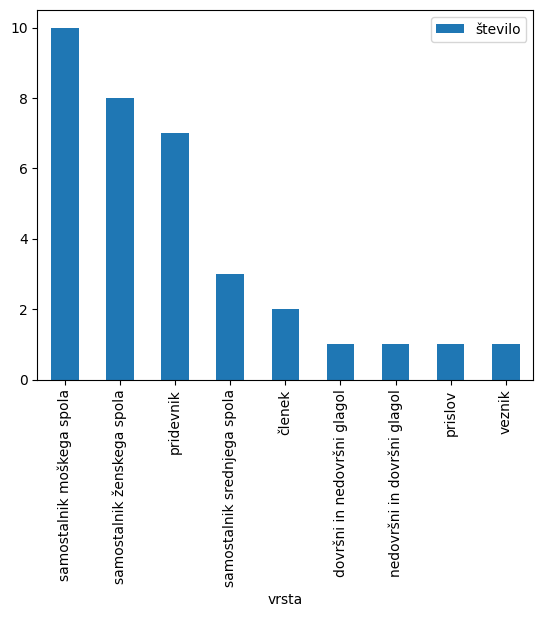

In [6]:
štetje_stolpca(razpredelnica, "vrsta").plot.bar()

Kot lahko vidite, to niso le besedna vrste ampak tudi dodatni podatki kot so spol in dovršnost. Zaradi teh dodatnih podatkov težje vidimo koliko je besed posamezne besedne vrste. Popravimo to. 

Spodnja koda doda kopiji originalne razpredelnice še eno vrstico poimenovano `"besedna vrsta"`, kjer je podana dejanska besedna vrsta besede.

In [7]:
raz_vrste = razpredelnica.copy()
for vrsta in besedne_vrste:
    raz_vrste.loc[raz_vrste["vrsta"].apply(lambda x: type(x) != float and vrsta in x), "besedna vrsta"] = vrsta
raz_vrste.loc[raz_vrste["vrsta"].apply(lambda x: type(x) == float), "besedna vrsta"] = "neznano"

# raz_vrste[["ime", "vrsta", "besedna vrsta"]].loc[raz_vrste["besedna vrsta"].isna()]
štetje_stolpca(raz_vrste, "besedna vrsta")

,število
besedna vrsta,
samostalnik,21
pridevnik,7
neznano,6
glagol,2
členek,2
prislov,1
veznik,1


Veliko bolje. Zdaj bo tudi graf natančnejši.

<Axes: xlabel='besedna vrsta'>

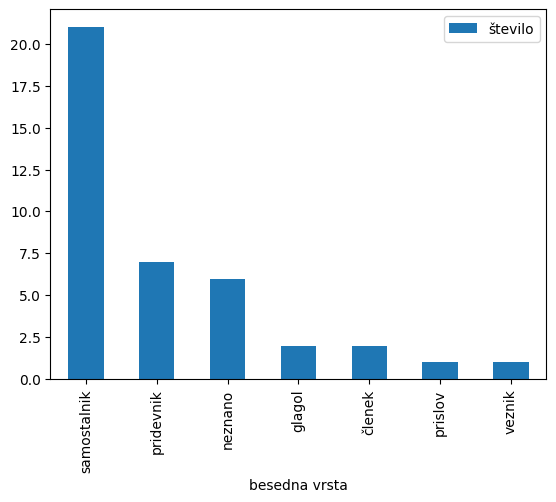

In [8]:
štetje_stolpca(raz_vrste, "besedna vrsta").plot.bar()

Sedaj ko smo uspeli ločiti besede na posamezne besedne vrste, lahko iščemo povprečno besedo besedne vrste.
Povprečna beseda je tisti niz črk, za katerega velja, da je njegova dolžina toliko kolikor je povprečje dolžin besed (zaokroženo seveda na celo število) in njegova i-ta črka je tista, ki se največkrat pojavi na i-tem mestu besed. 

Funkcija `razpredelnica_vrste` vrne podtabelo željene besedne vrste. Na primer za samostalnike.

In [9]:
def razpredelnica_vrste(vrsta="", raz = razpredelnica):
    seznam = raz["vrsta"].apply(lambda x: type(x) != float and vrsta in x)
    return raz.loc[seznam]

razpredelnica_samostalnikov = razpredelnica_vrste("samostalnik")
razpredelnica_samostalnikov

,ime,vrsta
0,á,samostalnik moškega spola
7,ábak,samostalnik moškega spola
8,abalienácija,samostalnik ženskega spola
10,abbé,samostalnik moškega spola
11,abc,samostalnik moškega spola
12,abderít,samostalnik moškega spola
14,abderítstvo,samostalnik srednjega spola
16,abdikácija,samostalnik ženskega spola
18,abdómen,samostalnik moškega spola
20,abdúkcija,samostalnik ženskega spola


Funkcija `povprečna_beseda` vrne povprečno besedo neke razpredelnice. Torej najprej najde povprečno dolžino besed, nato pa s pomočjo pomožne funkcije `črka_besede`, ki vrne črko na poljubnem mestu besede, poišče katera črka je najpogostejša na posameznem mestu.

In [10]:

def črka_besede(i, beseda):
    if len(beseda)<=i:
        return 
    return beseda[i]

from collections import Counter
def povprečna_beseda(raz):
    try:
        dolžina = round(raz["ime"].apply(len).sum()/raz["ime"].count())
    except ValueError:
        return "Oprosti, te besedne vrste ni v razpredelnici"
    odg = ""
    for i in range(dolžina):
        seznam = raz["ime"].apply(lambda beseda: črka_besede(i, beseda))
        crke = Counter(seznam).most_common() 
        if crke[0][0] == None: #Če je večina besed krajših od i
            odg += crke[1][0]
        else:
            odg += crke[0][0]
    return odg

povprečna_beseda(razpredelnica_vrste(""))

'abecédnr'

In [11]:
def besedičenje(raz):
    beeeseda = povprečna_beseda(raz)
    import re
    seznam = re.findall(
        r'(\w)(?!\1)'
        , beeeseda, re.DOTALL
    )
    beseda = ""
    for c in seznam:
        beseda += c
    if beseda in raz["ime"]:
        return beseda
    besede = set()
    
    v = 3
    for i in range(len(beseda)*v):
        for ime in raz["ime"]:
            if (beseda in ime and len(ime) == len(beseda)+i) or( beseda[:len(beseda)-i//v] == ime) or (beseda[:len(beseda)-i//v] in ime and len(ime) == len(beseda)+i//v):
                besede.add(ime)
        if besede !=set():
            break
    
    return besede

vrsta = "členek"

print(f"povprečna beseda: {povprečna_beseda(razpredelnica_vrste(vrsta))}")
print(f"potencialne povprečne besede, ki obstajajo:")
for beseda in besedičenje(razpredelnica_vrste(vrsta)):
    print(beseda)

povprečna beseda: à
potencialne povprečne besede, ki obstajajo:
à


Še ena zanimiva stvar za analizirati bi bila pogostost posamezne črke.

Funkcija `štetje_črk` prešteje kolikokrat se ponovi posamezna črka v poljubni razpredelnici.

In [12]:
def štetje_črk(raz, bes):
    if bes == True:
        st = 0
        for ime in raz["ime"]:
            st += len(ime)
        return st
    if bes == False:
        st = 0
        for ime in raz["ime"]:
            st += sum([not c.isalpha() for c  in ime])
        return st
    
    bes = bes.replace("a", "aáà").replace("e", "eéèê").replace("o", "oóòô").replace("i", "iíì")
       
    st = 0
    for c in bes:
        for ime in raz["ime"]:
            st += ime.count(c)
    return st
štetje_črk(razpredelnica, "t")

9

Funkcija `razpredelnica_črk` sprejme razpredelnico ali seznam razpredelnic, ter opcijsko oznake za stolpce, in vrne tabelo, ki pove kolikokrat se v posamezni razpredelnici besed ponovi posamezna črka, ter kolikšen delež vseh črk predstavlja ta črka izražen v procentih. S tem lahko primerjamo pogostost črk med različnimi besenimi vrstami.

In [13]:
def razpredelnica_črk(sez_raz, oznake=None):
    if oznake != None:
        prave_oznake = ["črka"]
        for oznaka in oznake:
            prave_oznake.append(oznaka)
            prave_oznake.append(oznaka+" %")
    else:
        prave_oznake = None
    
    if type(sez_raz) != list:
        sez_raz = [sez_raz]
    seznam = [list(abeceda)]
    for raz in sez_raz:
        štetje = []
        procent = []
        skupaj = sum([len(c) for c in raz["ime"]])
        for c in abeceda:
            st = štetje_črk(raz, c)
            štetje.append(st)
            try:
                procent.append(round(st/skupaj*100, 3))
            except ZeroDivisionError:
                procent.append(None)
        seznam.append(štetje)
        seznam.append(procent)
    return pd.DataFrame(seznam, index=prave_oznake).transpose()

razpredelnica_črk([razpredelnica_samostalnikov, razpredelnica], ["samostalniki", "vse"])

,črka,samostalniki,samostalniki %,vse,vse %
0,a,39,22.807,66,21.154
1,b,21,12.281,34,10.897
2,c,15,8.772,24,7.692
3,č,1,0.585,2,0.641
4,d,13,7.602,21,6.731
5,e,26,15.205,43,13.782
6,f,0,0.0,0,0.0
7,g,1,0.585,1,0.321
8,h,0,0.0,0,0.0
9,i,12,7.018,35,11.218


Poglejmo si primerjavo števila črk med različnimi besednimi vrstami na grafu. 

Glede na podatke bi bilo primernejše uporabiti stolpični diagram za prikaz, vendar sem se odličila, da so podatki lažje razvidni iz črtnega diagrama.

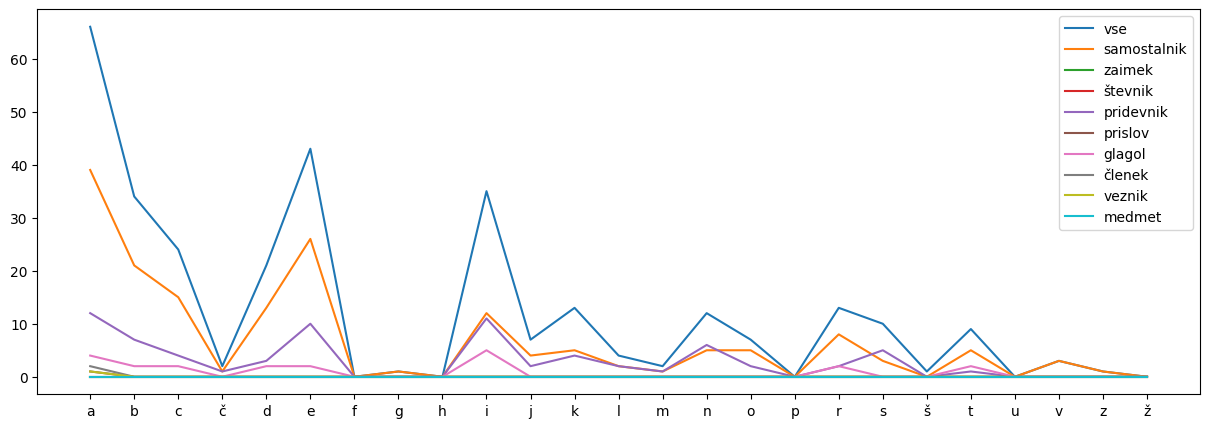

In [14]:
graf = razpredelnica_črk([razpredelnica]+[razpredelnica_vrste(vrsta) for vrsta in besedne_vrste], oznake=["vse"]+besedne_vrste)[["vse"]+besedne_vrste].plot.line(figsize=(15, 5))
graf.set_xticks(range(len(abeceda)));
graf.set_xticklabels(list(abeceda));

Najbrž nam bo graf pogostosti črk povedal več.

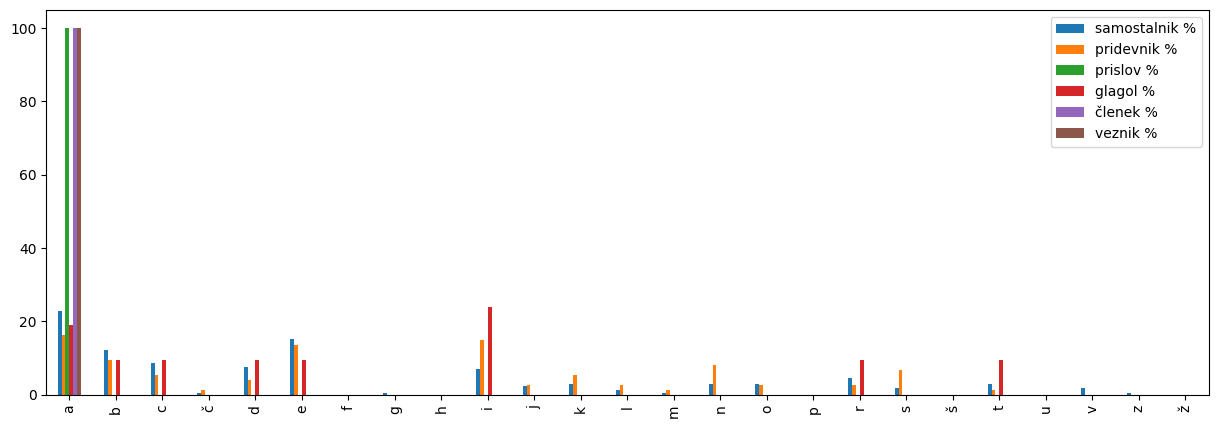

In [15]:
graf = razpredelnica_črk([razpredelnica_vrste(vrsta) for vrsta in besedne_vrste], oznake=besedne_vrste)[map(lambda x: x+" %", besedne_vrste)].plot.bar(figsize=(15, 5))
graf.set_xticks(range(len(abeceda)));
graf.set_xticklabels(list(abeceda));